
# <b>Tutorial 2: Data Preparation and visualisation</b>



## Learning Objectives:

In this session we will learn: 
1. How to perform further cube operations
2. How to prepare data for analysis
4. How to visualise data 

<table>
 
  <tr>
    <td><img src="images/global_airtemp_cp.png" width=400 height=250></td>
    <td><img src="images/global_airtemp_ts.png" width=400 height=250></td>
    
  </tr>
</table>

## Contents

1. [Constraint and cube extraction](#extract)
2. [Basic cube calculations](#calc)
3. [Time series and spatial plots](#plots)
4. [Saving the cube](#save)
5. [Exercises](#exercise)

<div class="alert alert-block alert-warning">
<b>Prerequisites</b> <br> 
- Basic programming skills in python<br>
- Familiarity with python libraries Iris, Numpy and Matplotlib<br>
- Basic understanding of climate data<br>
</div>

___

## 1. Constraint and cube extraction<a id='extract'></a>

### 1.1 Import libraries.
Import the necessary libraries. Current datasets are in zarr format, we need zarr and xarray libraries to access the data

In [1]:
import numpy as np
import xarray as xr
import zarr
import iris
import os
from cssp_utils import zarr_reader
from xarray_iris_coord_system import XarrayIrisCoordSystem as xics
xi = xics()
xr.set_options(display_style='text') # Work around for AML bug that won't display HTML output.

### 1.2 Set up authentication for the Azure blob store

The data for this course is held online in an Azure Blob Storage Service. To access this we use a SAS (shared access signature).  You should have been given the credentials for this service before the course, but if not please ask your instructor. We use the getpass module here to avoid putting the token into the public domain. Run the cell below and in the box enter your SAS and press return. This will store the password in the variable SAS.

In [2]:
import getpass
# SAS WITHOUT leading '?'
SAS = getpass.getpass()

 ····················································································


In [3]:
store = zarr.ABSStore(container='metoffice-20cr-ds', prefix='monthly/', account_name="metdatasa", 
                      blob_service_kwargs={"sas_token":SAS})
type(store)

zarr.storage.ABSStore

### 1.3 Read monthly data
A Dataset consists of coordinates and data variables. Let's use the xarray's **open_zarr()** method to read all our zarr data into a dataset object and display it's metadata

In [4]:
# use the open_zarr() method to read in the whole dataset metadata
dataset = xr.open_zarr(store)
# print out the metadata
dataset

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 203, grid_latitude_1: 202, grid_longitude: 270, grid_longitude_1: 270, pressure: 17, time: 1920)
Coordinates:
  * grid_latitude                              (grid_latitude) float32 21.119...
  * grid_latitude_1                            (grid_latitude_1) float32 21.0...
  * grid_longitude                             (grid_longitude) float32 325.2...
  * grid_longitude_1                           (grid_longitude_1) float32 325...
  * pressure                                   (pressure) float32 10.0 ... 10...
  * time                                       (time) datetime64[ns] 1851-01-...
Data variables:
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    air_temperature_maximum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_mean                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_minimum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure        (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    relative_humidity_mean                     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_temperature                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    x_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    x_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>
    y_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    y_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>

Convert dataset into iris cubelist

In [5]:
# create an empty list to hold the iris cubes
cubelist = iris.cube.CubeList([])
# use the DataSet.apply() to convert the dataset to Iris Cublelist
dataset.apply(lambda da: cubelist.append(xi.to_iris(da)))
# print out the cubelist
cubelist

[<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of cloud_area_fraction / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of geopotential_height / (m) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of lagrangian_tendency_of_air_pressure / (Pa s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of specific_humidity / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_air_pressure / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_longwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_shortwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>]

The cubelist printed above holds all of the data from the Zarr file in a list. To see more detail on each of the cubes in the list click on it. That shows a table with information about the name and units of the cube, its shape and coordinates.

We will see in the next section how to obtain a single cube for use in our analysis and visualisation.

---

### 1.4 Indexing the cube
**AIM:** Extract the ***cloud_area_fraction*** data and index it by a subset of latitudes and longitudes values

</pre>
<div class="alert alert-block alert-info">
<b>Note:</b> Cubes can be indexed in a similar manner to that of NumPy arrays. The result of indexing a cube is always a copy of the cube.
    
</div>

In [ ]:
# extract the variale from cubelist
caf = cubelist.extract_strict('cloud_area_fraction')
caf

In [ ]:
# subsetting the lat/lon values by indexing the first 10 values
subset_caf = caf[..., :10, :10]
subset_caf

In [ ]:
# subseting the cube with 50th to 99th lat/lon values at time index 10
subset_caf = caf[10, 50:100, 50:100]
subset_caf

<div class="alert alert-block alert-info">
<b>Note:</b> The extract above returns a 2 dimensional cube with latitude/longitude at a single time. Note that time is now a scalar (a single time: 1851-11-16 00:00:00)
    
</div>

In [ ]:
# Extracting first 10 elements from time dimension
subset_caf = caf[:10]
subset_caf

### 1.5 Time constraint
**AIM:** Use constraint and extract methods to subset a cube or cubelist.

The monthly data ranges from 1850 to 2000. In some cases we might not need all the time series and we might only be interested in 50 years 1950 - 2000.
In such cases, we can extract cube creating a time constraint. 
Let's extract "air_pressure_at_sea_level" cube, extract the cube containing data from 1950 to 2000 using time constraint.

<div class="alert alert-block alert-info">
<b>Note:</b> We've already seen above the <b>extract_strict</b> method to extract specific cube from cubelist. We can also apply constraints to a single cube (or a CubeList) using the respective <b>constraint</b> and <b>extract</b> methods.
 
Iris's <b>constraint</b> mechanism provides a powerful way to filter a subset of data from a larger collection. The Constraint constructor takes arbitrary keywords to constrain coordinate values.
    
<b>extract_strict</b> returns a single cube while <b>extract</b> methods returns a cubelist. If you use extract_strict and more or less than 1 cube matches then it is an error. 
    
</div>

In [ ]:
# Extracting air pressure at sea level cube from cublist 
air_pres = cubelist.extract_strict('air_pressure_at_sea_level')

In [ ]:
# Extracting from year 1950 to 2000
start_time = 1950
end_time = 2000
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
subcube = air_pres.extract(time_constraint)

To check if we have got the right cube, we can print start data and end date of subcube

In [ ]:
tcoord = subcube.coord('time')
units = tcoord.units
tdata = [units.num2date(point) for point in tcoord.points]
print('Start time: ',tdata[0])
print('End time:   ',tdata[-1])

<div class="alert alert-block alert-info">
<b>Note:</b> It is common to want to build a constraint for time.
This can be achieved by comparing cells containing datetimes

There are a few different approaches for producing time constraints in Iris. We focus here on one approach for constraining on time in Iris.

This approach allows us to access individual components of cell datetime objects and run comparisons on those.
    
</div>

Similar to constraining years, we can also constrain months and days

Consider a case where we want to get only a few months, like March, April and May, from our subcube

In [ ]:
# extracting month june, july and august from the list of years
month_constraint = iris.Constraint(time=lambda cell: cell.point.month in (3,4,5))
subcube.extract(month_constraint)

### 1.6 Extract region.

To make your analysis faster and easier, you can extract a smaller part of the model domain. In these examples we will work with Shanghai, but you can choose any region you want. 

<b>Note:</b> The original model data is on a rotated pole grid system which as seen in this diagram its coordinates are relative to the standard pole so we need to first get our data on to a standard grid system. We use the *extract_rot_method()* to do this.

<table>
 
  <tr>
    <td><img src="images/rotated_pole_1.png" width=400 height=250></td>
    <td><img src="images/rotated_pole_2.png" width=400 height=250></td>
    
  </tr>
</table>

In [ ]:
# let's first print the values of lat/lon before extracting
print('latitude: [', air_pres.coord('grid_latitude').points.min(), ', ', 
      air_pres.coord('grid_latitude').points.max(), ']')
print('longitude: [', air_pres.coord('grid_longitude').points.min(), ', ', 
      air_pres.coord('grid_longitude').points.max(), ']')

Let's try to extract Shanghai region using **extract_rot_cube**.

**extract_rot_cube** takes the latitude and longitude of the region of interest and returns a smaller cube with the extracted region of rotated pole coordinates. 

First define the lat lon of Shanghai region:

In [ ]:
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

In [ ]:
# load extract_rot_cube from catnip
from catnip.preparation import extract_rot_cube
ext_cube = extract_rot_cube(air_pres, min_lat, min_lon, max_lat, max_lon)
ext_cube

In [ ]:
# we can see that the min/max boundaries now changed
print('latitude: [', ext_cube.coord('grid_latitude').points.min(), ', ', 
      ext_cube.coord('grid_latitude').points.max(), ']')
print('longitude: [', ext_cube.coord('grid_longitude').points.min(), ', ', 
      ext_cube.coord('grid_longitude').points.max(), ']')

### 1.7 Constraint on cell methods and attributes

In our cubelist, we can see that we have four cubes named air_temperature: Minimum, Maximum and two Means (one with pressure level).
Let's try to extract air temperature and see what we get.


In [ ]:
air_temp = cubelist.extract('air_temperature')
air_temp

In order to get only one cube i.e. the time mean at the surface and not on the pressure levels, we need to constrain using the cell method. A [cell_method](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/build/ch07s03.html) is a piece of metadata which describes additional characteristics of a field.  Let try to create a constraint and use it to extract the desired cube.

In [ ]:
# constrain for the cube that does not have 'pressure' in its coordinate list
cube_cons_surf = iris.Constraint(cube_func=lambda c: 'pressure' not in [coord.name() for coord in c.coords()])
# also constrain to be only mean temperature 
cube_cons_mean = iris.Constraint(cube_func=lambda c: (len(c.cell_methods) > 0) and 
                                 (c.cell_methods[0].method == 'mean'))
# now apply the above constrains
air_temp_mean = air_temp.extract_strict(cube_cons_surf & cube_cons_mean)
air_temp_mean                              

Now we got desired cube. Now, if we look into minimum and maximum cubes, that does not contains cell method, instead, information lies in their respective attributes. 

We can extract, for example minimum cube, by constraining the attributes.

In [ ]:
min_cons = iris.Constraint(cube_func=lambda c: ('ukmo__process_flags' in c.attributes) and 
                           (c.attributes['ukmo__process_flags'][0].split(' ')[0] == 'Minimum'))
air_temp_min = air_temp.extract_strict(min_cons)
air_temp_min                              

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li>Extract from cubelist <b>relative humidity</b> cube: <b>year</b>: 1900-2000, <b>months</b>: May-September <b>Cell method</b>: Mean (4 hours) 

  
</div>


In [6]:
# First extracting relative_humidity cubes from cublist 
rel_hum = cubelist.extract('relative_humidity')
rel_hum

[<iris 'Cube' of relative_humidity / (%) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; grid_latitude: 203; grid_longitude: 270)>]

In [7]:
# Next constrain for the cube with mean(4 hour) as its cell method value
# This the cube that has 'pressure' in its coordinate list i.e. the first one
cons_pressure = iris.Constraint(cube_func=lambda c: 'pressure' in [coord.name() for coord in c.coords()])
cons_pressure_rel_hum = rel_hum.extract_strict(cons_pressure)
cons_pressure_rel_hum

<iris 'Cube' of relative_humidity / (%) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>

In [8]:
# Now that we have the right cube let's constraint by time
start_time = 1900
end_time = 2000
# year constraint
year_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# extracting months May-September
month_constraint = iris.Constraint(time=lambda cell: cell.point.month in (5,6,7,8,9))

time_constraint_rel_hum_subcube = cons_pressure_rel_hum.extract(year_constraint&month_constraint)
time_constraint_rel_hum_subcube

<iris 'Cube' of relative_humidity / (%) (time: 505; pressure: 17; grid_latitude: 203; grid_longitude: 270)>

In [9]:
# we can print the time coordinate values to be sure
tcoord = time_constraint_rel_hum_subcube.coord('time')
units = tcoord.units
tdata = [units.num2date(point) for point in tcoord.points]
print('Start time: ',tdata[0])
print('End time:   ',tdata[-1])


Start time:  1900-05-16 12:00:00
End time:    2000-09-16 00:00:00


___

## 2. Basic Calculations<a id='calc'></a>

### 2.1 Calculating mean, max, min
In this section we will use **iris.analysis** method to calculate basic mean, min and max values. But before we do this we need to undrestand two important concepts/techniques that is used in the analysis code to follow:
1. Before we can do any analysis on spatial coordinates we need to be able to calculate the area of each grid box. and for this we need to know the boundaries of each grid box. If the longitude and latitude bounds are not defined in the cube we can guess the bounds based on the coordinates point values and that is what the *guess.bounds()* function does in the code below.
2. Once we have our longitude and latitude boundaries we can use the *iris.analysis.cartography.area_weights* to compute the data as a weighted mean of all grid-boxes. The *area_weights()* function returns an array of area weights, with the same dimensions as the cube where a larger cell has more weight in the average than a smaller one.

Now let's extract the *surface_temperature* and calculate mean over the whole region.  

In [ ]:
#  extract surface_temerature
sft = cubelist.extract_strict('surface_temperature')

Using the **collapsed** and **analysis** methods over grid_latitude and grid_longitude, we can get the timeseries of mean over the whole domain.

In [ ]:
import iris.analysis.cartography

# Since grid_latitude and grid_longitude were both point coordinates we must guess bound positions 
# for them in order to calculate the area of the grid boxes
sft.coord('grid_latitude').guess_bounds()
sft.coord('grid_longitude').guess_bounds()

grid_areas = iris.analysis.cartography.area_weights(sft)

# calculating mean using area_weights method
sft_mean = sft.collapsed(['grid_longitude', 'grid_latitude'], iris.analysis.MEAN, weights=grid_areas)
sft_mean

<div class="alert alert-block alert-info">
<b>Note:</b> The above cube has reduced to only one dimension i.e. "time"

    
<br>iris.analysis provides a range of statistical methods, see [iris.analysis dcumentation](https://scitools.org.uk/iris/docs/v1.9.0/html/iris/iris/analysis.html)
    
<br> Collapse method can be applied to one, more or all the dimensions.
</div>

### 2.2 Basic arithmetic operations

Basic arithmetic operations like addition, subtraction, multiplication, square root, power etc. can be performed on iris cube.

Let's calculate 10m windspeed using **x_wind** and **y_wind** cubes.

In our cubelist, we have two variables with same cell method. We can constraint using coordinates information.

To calculate 10m windspeed we need data which is not on pressure levels.

In [ ]:
# extract x_wind and y_wind
xcons = iris.Constraint(cube_func=lambda c: c.standard_name == 'x_wind' and 
                        ('pressure' not in [coord.name() for coord in c.coords()]))
ycons = iris.Constraint(cube_func=lambda c: c.standard_name == 'y_wind' and 
                        ('pressure' not in [coord.name() for coord in c.coords()]))

u = cubelist.extract_strict(xcons)
v = cubelist.extract_strict(ycons)

Let's create a windspeed cube by copying the u cube first

In [ ]:
windspeed = u.copy()

Calculate windspeed:

In [ ]:
import numpy as np
windspeed.data = np.sqrt(u.data**2 + v.data**2)
windspeed

We see that cube name is "x_wind", that is becuase we copied the u_cube. We can rename it to "windspeed"

In [ ]:
windspeed.rename("wind speed")
windspeed

<div class="alert alert-block alert-info">
<b>Note:</b> When performing arithmetic calculation, consider the units, name and other metadata information. 
</div>

___

## 3. Time series and spatial plots<a id='plots'></a>

### 3.1 Time series plots
Using iris quick plot to create time series plots. Let's load the necessary libraries first.


In [ ]:
# we first need to load libraries for plotting 
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt

Let's plot the timeseries of mean surface temeprature over Shanghai region from 1950 - 2000

In [ ]:
# loading mean air temperature 
sft = cubelist.extract_strict('surface_temperature')
sft.coord_system()
sft

In [ ]:
# Shanghai region coordinates 
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0
# load extract_rot_cube from catnip
from catnip.preparation import extract_rot_cube
sft_shangai = extract_rot_cube(sft, min_lat, min_lon, max_lat, max_lon)
sft_shangai

In [ ]:
# Now constrain over time
start_time = 1950
end_time = 2000
time_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)
sft_tim = sft_shangai.extract(time_constraint)
sft_tim

In [ ]:
# collapse the longitude and latitude and calculate mean over the time period
timeseries = sft_tim.collapsed(['grid_latitude','grid_longitude'], iris.analysis.MEAN)
timeseries

Lets plot the timeseries using a standard matplotlib library.


In [ ]:
# ploting with matplotlib 
plt.plot(timeseries.data)
plt.show()

We have got the time series values. Now we can plot them using the [**iris quickplot**](https://scitools.org.uk/iris/docs/latest/iris/iris/quickplot.html?highlight=quickplot).[what does this add?]

In [ ]:
# plotting with the quickplot 
qplt.plot(timeseries)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> <b>iris.quickplot</b> adds extra automatic labelling: axes are labelled with a coordinate name and units, and the plot title is taken from the cube name. On the other hand using matplotlib.plot we need to add labels and title manually. 
</div>

### 3.2 Contour plots
Using iris quick plot to create contour plots

Let's plot the average surface temperature from 1900 to 2000 over Shangai region.

We can collapse 'time' dimension of sft_tim cube to get the spatial mean 

In [ ]:
spatial_mean = sft_tim.collapsed(['time'], iris.analysis.MEAN)

Now that we have the mean values we can make a spatial contour plot using the iris quickplot contourf method

In [ ]:
# plot the surface temperature contour at the first timestep 
qplt.contourf(spatial_mean)
# add some coastlines for context
plt.gca().coastlines()
# set the figure size
plt.gcf().set_size_inches(8,12)
plt.show()

<div class="alert alert-block alert-info">
<b>Note:</b> <b>iris.quickplot</b> also adds the colorbar
</div>

<div class="alert alert-block alert-success">
    <b>Task:</b><br><ul>
        <li>Plot time series of maximum air temperature from 1900 to 2000 of only summer season (June, July and August)</li>
        <li>Plot contour plot of the maximum air temperature from 1900 to 2000 of only summer season (June, July and August)</li>
    </ul>
</div>


/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/cube.py:3218: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_latitude'.
  warnings.warn(msg.format(self.name()))
/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'grid_longitude'.
  warnings.warn(msg.format(self.name()))


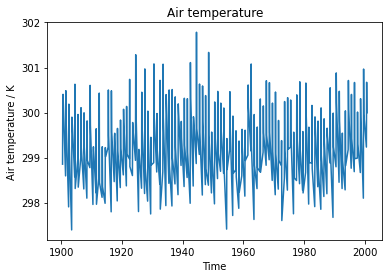

In [14]:
# first extracting the air temperature from cubelist
air_temp = cubelist.extract('air_temperature')

# define constraint for maximum air temperature
max_cons = iris.Constraint(cube_func=lambda c: ('ukmo__process_flags' in c.attributes) and 
                           (c.attributes['ukmo__process_flags'][0].split(' ')[0] == 'Maximum'))
#air_temp_max = air_temp.extract_strict(max_cons)

# define time constraints
start_time = 1900
end_time = 2000
# year constraint
year_constraint = iris.Constraint(time=lambda cell: start_time <= cell.point.year <= end_time)

# extracting only summer season (June, July and August)
month_constraint = iris.Constraint(time=lambda cell: cell.point.month in (6,7,8))

constraint_air_temp_max = air_temp.extract_strict(max_cons&year_constraint&month_constraint)

# we first need to load libraries for plotting 
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt


# collapse the longitude and latitude and calculate mean over the time period
timeseries = constraint_air_temp_max.collapsed(['grid_latitude','grid_longitude'], iris.analysis.MEAN)

# plotting with the quickplot 
qplt.plot(timeseries)
plt.show()

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


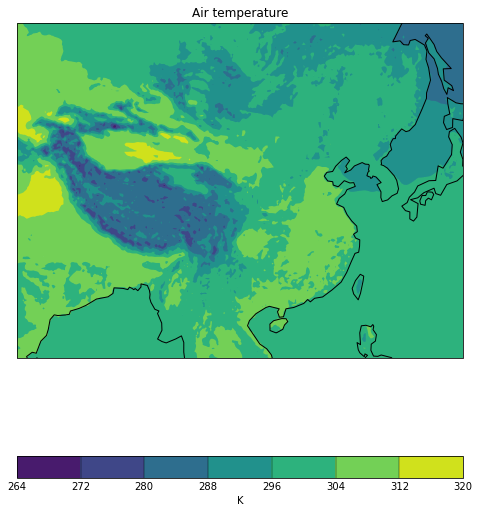

In [15]:
# collapse 'time' dimension of the cube to get its spatial mean
spatial_mean = constraint_air_temp_max.collapsed(['time'], iris.analysis.MEAN)

# plot the surface temperature contour at the first timestep 
qplt.contourf(spatial_mean)
# add some coastlines for context
plt.gca().coastlines()
# set the figure size
plt.gcf().set_size_inches(8,12)
plt.show()

___

## 4. Saving the cube<a id='save'></a>

### 4.1 Save the cube in zarr store
We can save our cube in zarr store to be used later. 

For this purpose, we first need to convert cube into xarray and then save it into zarr store.

Let's save 'spatial_mean' cube from the above section.

In [ ]:
# converting cube back to xarray
sft_mean = xr.DataArray.from_iris(spatial_mean)

# rename the xarray
sft_mean.rename('surface_temperature_mean')

# checking the chunk size of the xarray
sft_mean.chunks

In [ ]:
# convert the xarray into dataset
sft_mean_ds = sft_mean.to_dataset()

# path to where store the zarr data
zarr_store = f"{os.environ['HOME']}/zstore"

# store the dataset to specfied path as zarr data store
sft_mean_ds.to_zarr(zarr_store, consolidated=True, mode='w')

___

## 5. Exercises<a id='exercise'></a>

In this exercise we will analyse the mean precipitation rate from 1950 - 2010 over the Shanghai region

### Exercise 1: Load monthly data

In [16]:
# first get and store object to access the zarr data
store = zarr.ABSStore(container='metoffice-20cr-ds', prefix='monthly/', account_name="metdatasa", 
                      blob_service_kwargs={"sas_token":SAS})
type(store)

# use the open_zarr() method to read in the whole dataset metadata
dataset = xr.open_zarr(store)
# print out the metadata
dataset

<xarray.Dataset>
Dimensions:                                    (grid_latitude: 203, grid_latitude_1: 202, grid_longitude: 270, grid_longitude_1: 270, pressure: 17, time: 1920)
Coordinates:
  * grid_latitude                              (grid_latitude) float32 21.119...
  * grid_latitude_1                            (grid_latitude_1) float32 21.0...
  * grid_longitude                             (grid_longitude) float32 325.2...
  * grid_longitude_1                           (grid_longitude_1) float32 325...
  * pressure                                   (pressure) float32 10.0 ... 10...
  * time                                       (time) datetime64[ns] 1851-01-...
Data variables:
    air_pressure_at_sea_level                  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_at_pressure_mean           (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    air_temperature_maximum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_mean                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    air_temperature_minimum                    (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    cloud_area_fraction                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    geopotential_height                        (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    lagrangian_tendency_of_air_pressure        (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    precipitation_flux                         (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    relative_humidity_at_pressure_mean         (time, pressure, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 1, 203, 270), meta=np.ndarray>
    relative_humidity_mean                     (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    specific_humidity                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_air_pressure                       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_longwave_flux_in_air   (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    surface_temperature                        (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(200, 203, 270), meta=np.ndarray>
    x_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    x_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>
    y_wind_at_pressure_mean                    (time, pressure, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 1, 202, 270), meta=np.ndarray>
    y_wind_mean                                (time, grid_latitude_1, grid_longitude_1) float32 dask.array<chunksize=(200, 202, 270), meta=np.ndarray>

In [17]:
# the dataset list is ok in text format but looks better as cubelist 
# so let's convert the dataset to Iris Cublelist

# create an empty list to hold the iris cubes
cubelist = iris.cube.CubeList([])
# use the DataSet.apply() to convert the dataset to Iris Cublelist
dataset.apply(lambda da: cubelist.append(xi.to_iris(da)))
# print out the cubelist
cubelist

[<iris 'Cube' of air_pressure_at_sea_level / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of air_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of cloud_area_fraction / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of geopotential_height / (m) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of lagrangian_tendency_of_air_pressure / (Pa s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; pressure: 17; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of relative_humidity / (%) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of specific_humidity / (unknown) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_air_pressure / (Pa) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_longwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_downwelling_shortwave_flux_in_air / (W m-2) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of surface_temperature / (K) (time: 1920; grid_latitude: 203; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of x_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; pressure: 17; grid_latitude: 202; grid_longitude: 270)>,
<iris 'Cube' of y_wind / (m s-1) (time: 1920; grid_latitude: 202; grid_longitude: 270)>]

### Exercise 2: Extract precipitation_flux

In [18]:
# Now let's load the precipitation_flux cube
precipitation_cube = cubelist.extract_strict('precipitation_flux')
precipitation_cube

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 1920; grid_latitude: 203; grid_longitude: 270)>

### Exercise 3: calculate mean

In [19]:
import iris.analysis.cartography

# Since grid_latitude and grid_longitude were both point coordinates we must guess bound positions 
# for them in order to calculate the area of the grid boxes
precipitation_cube.coord('grid_latitude').guess_bounds()
precipitation_cube.coord('grid_longitude').guess_bounds()

grid_areas = iris.analysis.cartography.area_weights(precipitation_cube)

# calculating mean using area_weights method
precipitation_mean = precipitation_cube.collapsed(['grid_longitude', 'grid_latitude'], 
                                                  iris.analysis.MEAN, weights=grid_areas)
precipitation_mean

Precipitation Flux (kg m-2 s-1),time
Shape,1920
Dimension coordinates,
time,x
Scalar coordinates,
grid_latitude,"-1.1000013 degrees, bound=(-23.430002, 21.23) degrees"
grid_longitude,"354.83002 degrees, bound=(325.13, 384.53003) degrees"
Attributes,
source,Data from Met Office Unified Model
Cell methods,
mean,time (1 hour)


### Exercise 4: Plot timeseries

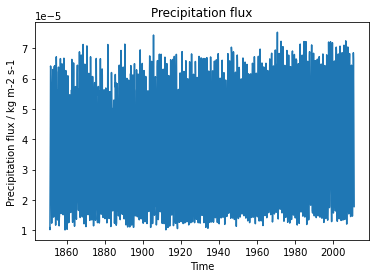

In [20]:
import iris.quickplot as qplt
import matplotlib.pyplot as plt

# plotting with the quickplot 
qplt.plot(precipitation_mean)
plt.show()

### Exercise 5: Spatial plot over Shanghai

/anaconda/envs/cssp37/lib/python3.7/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


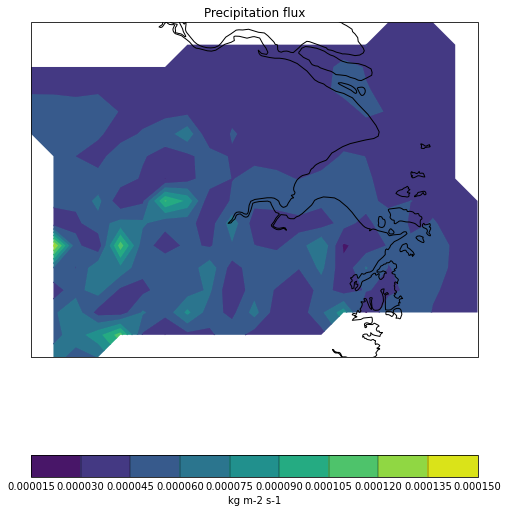

In [21]:
# Shanghai region coordinates 
min_lat=29.0
max_lat=32.0
min_lon=118.0
max_lon=123.0

# Use extract_rot_cube from catnip to extract for Shanghai region
from catnip.preparation import extract_rot_cube
precipitation_shangai = extract_rot_cube(precipitation_cube, min_lat, min_lon, max_lat, max_lon)

# collapse 'time' dimension of the cube to get its spatial mean
precipitation_shangai_spatial_mean = precipitation_shangai.collapsed(['time'], iris.analysis.MEAN)

# plot the surface temperature contour at the first timestep 
qplt.contourf(precipitation_shangai_spatial_mean)
# add some coastlines for context
plt.gca().coastlines()
# set the figure size
plt.gcf().set_size_inches(8,12)
plt.show()

___

</pre>
<div class="alert alert-block alert-success">
<b>Summary</b><br> 
    In this session we learned how:<br>
    <ul>
        <li>to prepre sube for analysis</li>
        <li>to perform basic arithmatic operation</li>
        <li>to plot timeseries and contours </li>
        <li>to save data in zarr format </li>
    </ul>

</div>
